# Hierarchical model
The hierarchical model is implemented in `Stan` as described in Section V of the paper. Here we show the case of a positive source evolution prior as an example, bu the extension to other cases is simple using the information in the paper to change the inputs. For the case of the unconstrained prior, use the stan model provided in `stan/nu_pop_model_unconst.stan`.

The full fits generally take a few hours to run, and the samples used in the paper are also provided in `samples`, so it is possible to skip straight to the posterior section of this notebook.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import h5py
import stan_utility

## Setup
Relevant for the positive and negative source evolution priors.

In [ ]:
# Theta parameters for the positive prior (see Table II in the paper)
p1 = 19.3
p2 = 24.9
zc = 1.76

# Detector assumptions
sigma_Phi = 0.25
sigma_gamma = 0.1

In [ ]:
# Pdet parametrisation
pdet_file = "../1_detection_probability/output/pdet_params_Nevents497.h5"
with h5py.File(pdet_file, 'r') as f:
    sindec_bins = f['sindec_bins'][()]
    index_grid = f['index_grid'][()]
    Pdet_cen = f['Pdet_cen'][()] * 1e3 # TeV cm^-2 s^-1 
    Pdet_width = f['Pdet_width'][()]

In [ ]:
stan_model = "stan/nu_pop_model.stan"
model = stan_utility.compile_model(filename=stan_model, 
                                   model_name="nu_pop_model", include_paths="stan/")

In [ ]:
fit_input = {}

fit_input['gamma_det'] = 2.19
fit_input['Emin'] = 10.0
fit_input['Emax'] = 1.0e4
fit_input['Enorm'] = 100.0
fit_input['Ns_det'] = 0
fit_input['Phi_norm_det'] = 1.01e-15 
fit_input['zmin'] = 1e-10
fit_input['zmax'] = 10

fit_input['p1_mean'] = p1
fit_input['p2_mean'] = p2
fit_input['zc_mean'] = zc
fit_input['p1_sd'] = 0.2
fit_input['p2_sd'] = 0.2
fit_input['zc_sd'] = 0.12

fit_input['sigma_Phi'] = sigma_Phi
fit_input['sigma_gamma'] = sigma_gamma

fit_input['Nd'] = len(sindec_bins)-1
fit_input['Ng'] = len(index_grid)
fit_input['sindec_bins'] = sindec_bins
fit_input['gamma_grid'] = index_grid
fit_input['Pdet_cen'] = Pdet_cen
fit_input['Pdet_width'] = Pdet_width

fit_input['L_mean'] = np.log(1e42)
fit_input['L_sd'] = 30.0
fit_input['n0_mean'] = np.log(1e-6)
fit_input['n0_sd'] = 30.0

# To switch between separate limits (e.g. right panels of Fig. 6)
fit_input['flux_only'] = 0
fit_input['Ns_only'] = 0

## Fit

In [ ]:
np.random.seed(42)
inits = []
for i in range(6):
    inits.append({'n0' : 10**np.random.uniform(-8, -4), 
                  'L' : 10**np.random.uniform(37, 45)})
    
fit = model.sampling(data=fit_input, iter=1500, chains=6, 
                     warmup=500, seed=42, init=inits)

In [ ]:
fit

In [ ]:
chain = fit.extract(permuted = True)

## Testing

In [ ]:
import corner

In [ ]:
key_list = ['L', 'n0']
labels = [r'log10(L)', r'log10(n_0)']
#truths = [np.log10(L), np.log10(n0)]

corner.corner(np.column_stack([np.log10(chain[key]) for key in key_list]),
              labels = labels,); 

In [ ]:
# Save to file
with h5py.File('samples/positive_prior_v1.h5', 'w') as f:
    for key in chain:
        f.create_dataset(key, data=chain[key])

## Posterior

In [5]:
import seaborn as sns
from plotting.posterior_plot import PosteriorPlot
from plotting.HPD_regions import HPD_contours
import matplotlib.patches as mpatches
TeV_to_erg = 1.60218

In [31]:
with h5py.File('samples/positive_prior.h5', 'r') as f:
    L = np.log10(f['L'][()] * TeV_to_erg) # TeV s^-1 -> erg s^-1
    n0 = np.log10(f['n0'][()])
    p1 = f["p1"][()]
    p2 = f["p2"][()]
    zc = f["zc"][()]
    
# Colours
colors = plt.cm.viridis(np.linspace(0, 1, 10))
c1 = colors[2]
c2 = colors[0]

### Fig. 6 

In [32]:
# Levels
target_levels = [0.99, 0.9, 0.6, 0.3] 
levels = HPD_contours(L, n0, levels=target_levels, kde=True, bins=200)

Text(0, 0.5, '$\\log_{10}(n_0 \\ / \\ \\mathrm{Mpc}^{-3})$')

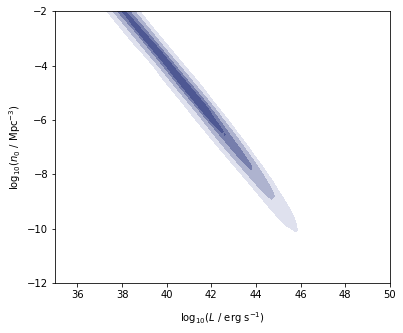

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
sns.kdeplot(L, n0, levels=levels, shade=True, color=c1)
ax.set_xlim(35, 50)
ax.set_ylim(-12, -2)
ax.set_xlabel('$\log_{10}(L \ / \ \mathrm{erg} \ \mathrm{s^{-1}})$', 
              labelpad=10)
ax.set_ylabel('$\log_{10}(n_0 \ / \ \mathrm{Mpc}^{-3})$')

### Fig. 7

In [34]:
from helper_functions import SFR_density, agn_density, source_evolution

In [35]:
combined_param = p1 - p2/zc

target_levels = [0.99, 0.9, 0.6, 0.3]
combined_levels = HPD_contours(combined_param, n0, target_levels)

Text(0, 0.5, '$\\log_{10}(n_0 \\ / \\ \\mathrm{Mpc}^{-3})$')

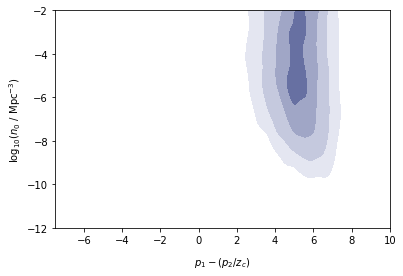

In [36]:
fig, ax = plt.subplots()
sns.kdeplot(combined_param, n0, levels=combined_levels, shade=True, color=colors[2])
ax.set_ylim(-12, -2)
ax.set_xlim(-7.5, 10)
ax.set_xlabel('$p_1 - (p_2/z_c)$', labelpad=10)
ax.set_ylabel('$\log_{10}(n_0 \ / \ \mathrm{Mpc}^{-3})$')